In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


cm = 1/2.54

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
norm_tpm = pd.read_csv('tables/scone_norm_tpm.tab.gz', sep='\t', index_col=0)
# norm_tpm = pd.read_csv('tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)


In [3]:
glia = norm_tpm.columns[(norm_tpm.loc['Hepacam'] >= 1) | (norm_tpm.loc['Ednrb'] >= 1)  | (norm_tpm.loc['Olig1'] >= 1) | (norm_tpm.loc['Ramp1'] >= 1) | (norm_tpm.loc['Aldh1l1'] >= 1)]
neurogenesis_cells = [x for x in norm_tpm.columns if x not in glia]
norm_tpm_neuro = norm_tpm[neurogenesis_cells]

In [4]:
from numba import jit

def compute_cell_metric_light(
    manifold, 
    n_neighbors=100, 
    weight_metric = True,
):
    
    
    cells = manifold.index
    n_cells = len(cells)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors+1).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    
    
    neighbor_indices = pd.DataFrame(indices, index=cells)
    
    weights = np.ones((len(cells), (n_neighbors+1)))
    
    for i in tqdm(range(len(manifold.index)), position=0, leave=True):
        sigma = np.max(distances[i])
        for j in range(1, len(distances[i])):
            d = distances[i][j]
            w = compute_weight(d, sigma)
            weights[i, j] = w
        
    cell_metric = (indices, weights)
    return cell_metric

# @jit(nopython=True)
def compute_weight(d, sigma):
    return np.exp(-(d**2)/(sigma**2)) 


In [5]:
high_expression = norm_tpm_neuro.index[norm_tpm_neuro.mean(axis=1) >= 0.1]
fano = (norm_tpm_neuro.loc[high_expression].var(axis=1)/norm_tpm_neuro.loc[high_expression].mean(axis=1)).sort_values()
pca_norm_tiklova = PCA(n_components=30)

scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_tpm_neuro.loc[fano.index[-1000:]].T).T,
                             index = fano.index[-1000:], columns = norm_tpm_neuro.columns)

# pca_norm_tiklova = pca_norm_tiklova.fit(norm_tpm_neuro.loc[var_genes & norm_tpm_neuro.index].T)

# pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm_neuro.loc[var_genes & norm_tpm_neuro.index].T)

pca_norm_tiklova = pca_norm_tiklova.fit_transform(scaled_counts.T)


rd = pd.DataFrame()
for i in range(30):
    rd['PC_' + str(i+1)] = pca_norm_tiklova.T[i]

rd.index = neurogenesis_cells
rd.PC_2 = - rd.PC_2


<IPython.core.display.Javascript object>


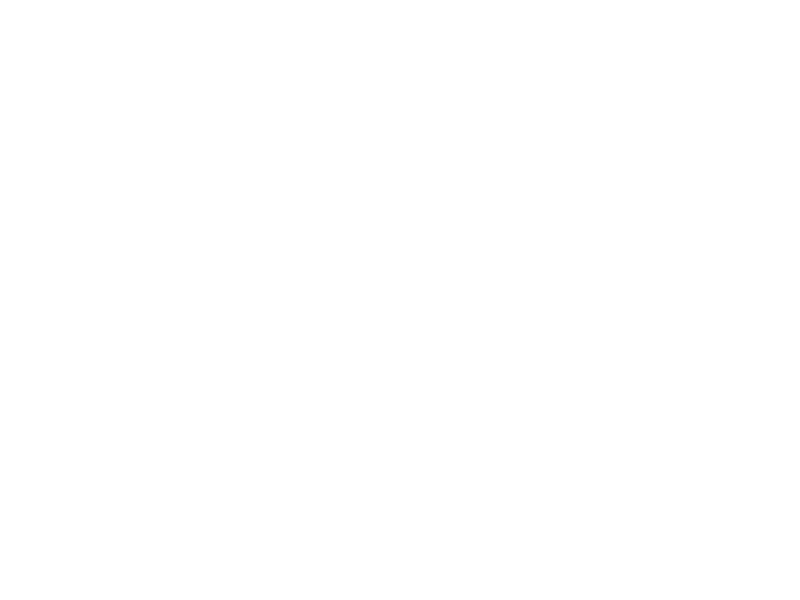

NameError: name 'colores' is not defined

In [6]:
high_expression = norm_tpm_neuro.index[norm_tpm_neuro.mean(axis=1) >= 0.1]
fano = (norm_tpm_neuro.loc[high_expression].var(axis=1)/norm_tpm_neuro.loc[high_expression].mean(axis=1)).sort_values()
pca_norm_tiklova = PCA(n_components=30)

scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_tpm_neuro.loc[fano.index[-1000:]].T).T,
                             index = fano.index[-1000:], columns = norm_tpm_neuro.columns)

# pca_norm_tiklova = pca_norm_tiklova.fit(norm_tpm_neuro.loc[var_genes & norm_tpm_neuro.index].T)

# pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm_neuro.loc[var_genes & norm_tpm_neuro.index].T)

pca_norm_tiklova = pca_norm_tiklova.fit_transform(scaled_counts.T)


rd = pd.DataFrame()
for i in range(30):
    rd['PC_' + str(i+1)] = pca_norm_tiklova.T[i]

rd.index = neurogenesis_cells
rd.PC_2 = - rd.PC_2



%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=colores)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

<IPython.core.display.Javascript object>


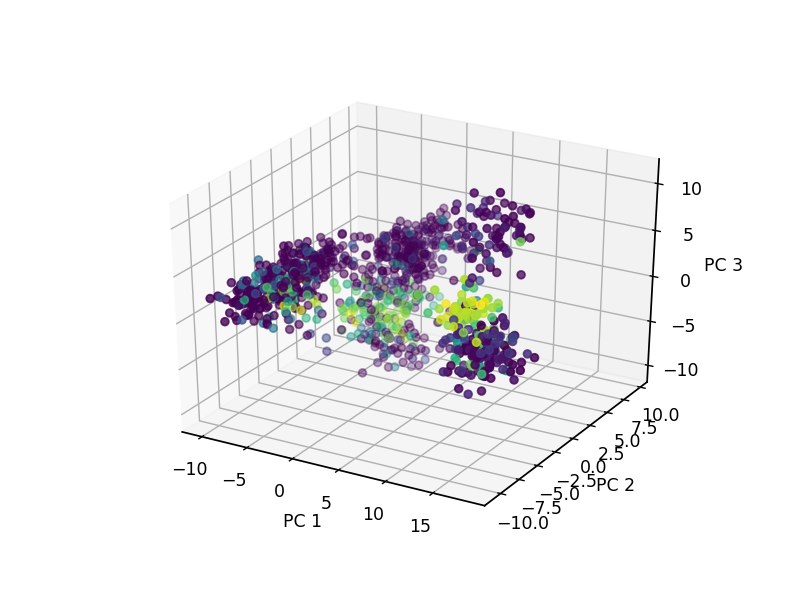

In [7]:

%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm.loc['Gad2', rd.index])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

In [6]:
# rd_old_ext = pd.read_csv('tables/pc3_rd_extended.tab.gz', sep='\t', index_col=0)

In [6]:
rd_old = pd.read_csv('tables/pc3_rd.tab.gz', sep='\t', index_col=0)

In [7]:
# plt.scatter(rd.PC_3,rd_old.PC_3)

In [8]:
np.mean(np.abs(rd.PC_3 - rd_old.PC_3))

0.0002851084529329714

In [31]:
# rd[['PC_1', 'PC_2', 'PC_3']].to_csv('tables/pc3_rd.tab.gz', sep='\t', index=True, header=True)

In [9]:
rd = rd_old

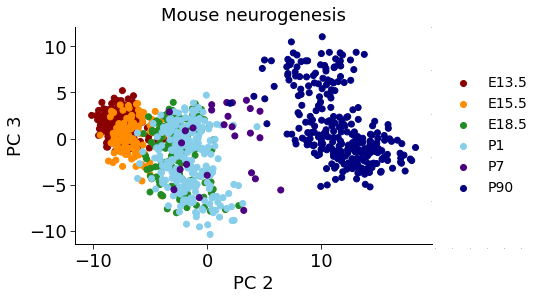

In [10]:

meta = pd.read_csv('../SraRunTable.txt.gz', index_col=0)

from matplotlib import pyplot as plt
colores = []
for cell in meta.loc[rd.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1,5)
gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(gs[0,0:4])
ax_2 = fig.add_subplot(gs[0,4])
ax.scatter(rd.PC_1, rd.PC_3, c=colores)
ax.tick_params(labelsize=18, length=5)
ax.set_title('Mouse neurogenesis', fontsize=18)
ax.set_xlabel('PC 2', fontsize=18)
ax.set_ylabel('PC 3', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax_2.scatter([-1], [0], c='darkred', label='E13.5')
ax_2.scatter([0], [0], c='darkorange', label='E15.5')
ax_2.scatter([0], [0], c='forestgreen', label='E18.5')
ax_2.scatter([0], [0], c='skyblue', label='P1')
ax_2.scatter([0], [0], c='indigo', label='P7')
ax_2.scatter([0], [0], c='navy', label='P90')
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["bottom"].set_visible(False)
ax_2.spines["left"].set_visible(False)
ax_2.tick_params(labelsize=0, length=0, which='both')
ax_2.set_xlim([2, 3])
ax_2.set_ylim([2, 3])
ax_2.legend(frameon=False, fontsize=14, loc='center left')

# plt.savefig('../../plots/PCA_neurogenesis.png', bbox_inches='tight', res=100)
# plt.savefig('../../plots/PCA_neurogenesis.svg', bbox_inches='tight')
# plt.savefig('../../plots/PCA_neurogenesis.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


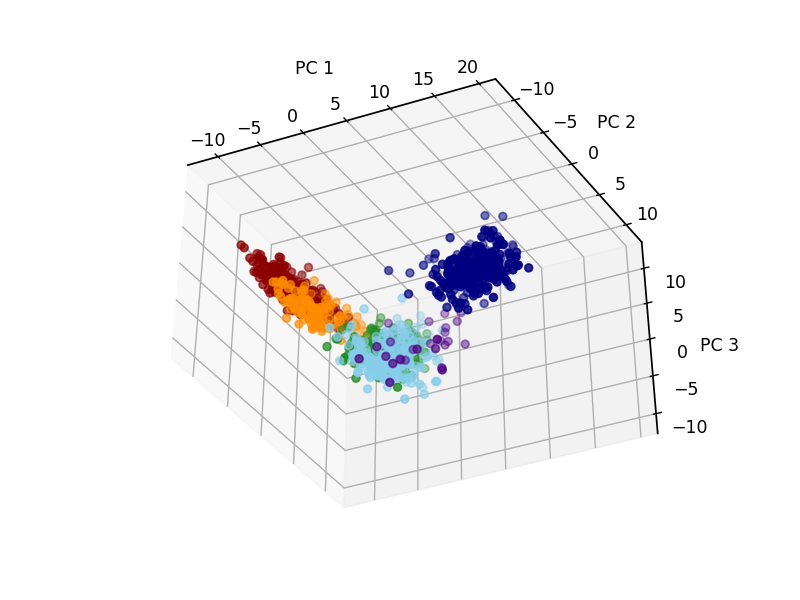

In [7]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=colores)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

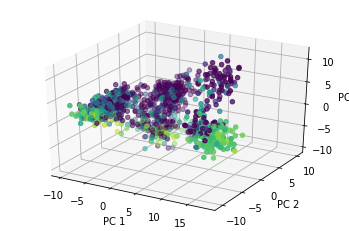

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Nxph4'])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

<IPython.core.display.Javascript object>


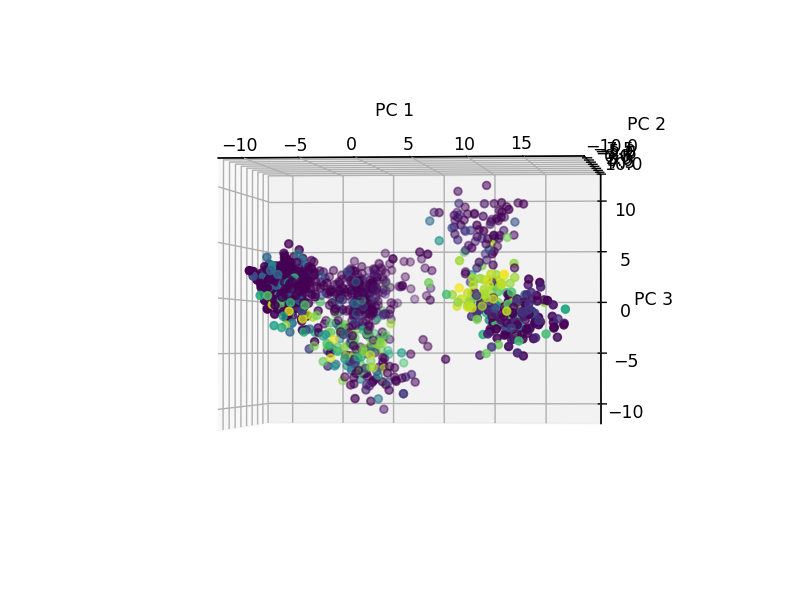

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Gad2'])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

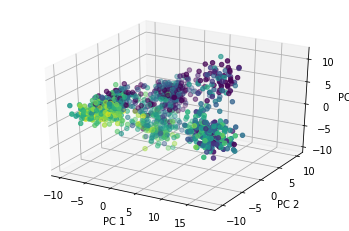

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Nova1'])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

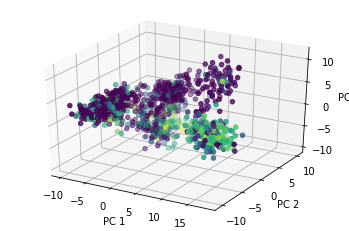

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Rbfox1'])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

<IPython.core.display.Javascript object>


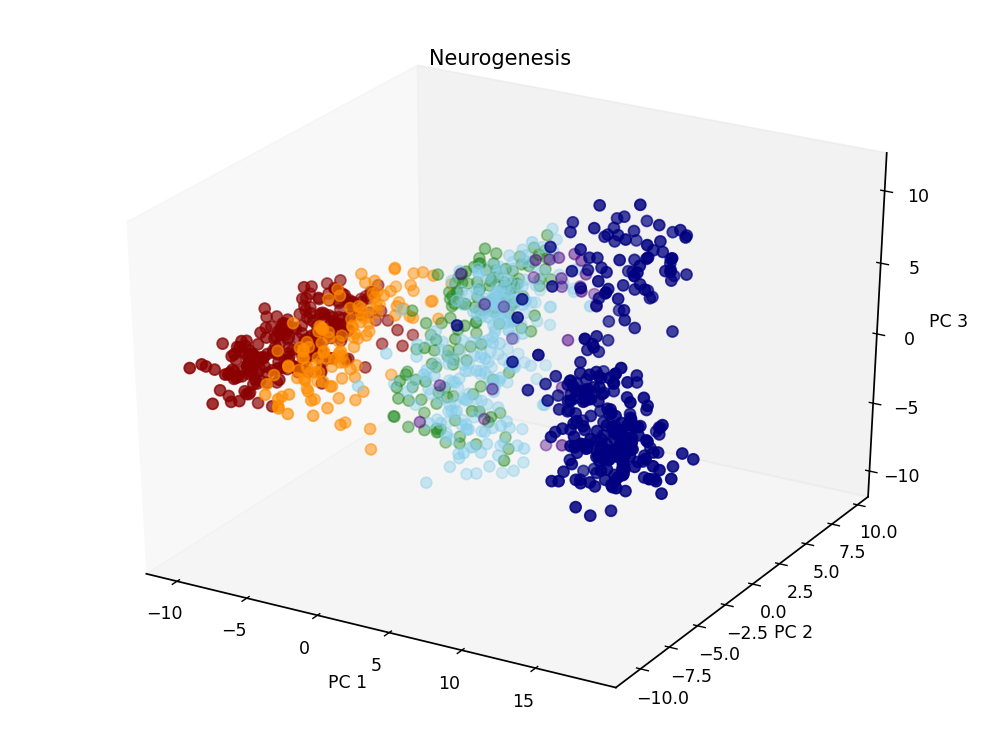

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=colores, s=40)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Neurogenesis')

plt.show()

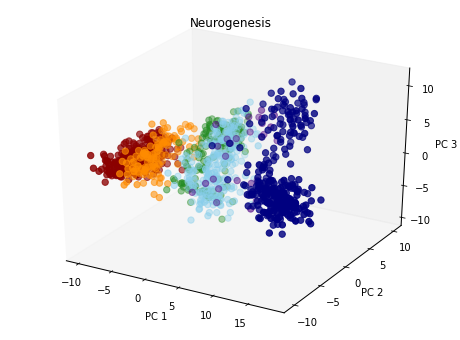

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=colores, s=40)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Neurogenesis')

plt.show()

<IPython.core.display.Javascript object>


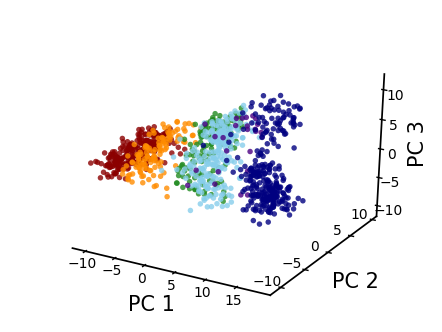

In [12]:
meta = pd.read_csv('../SraRunTable.txt.gz', index_col=0)
rd = pd.read_csv('tables/pc3_rd.tab.gz', sep='\t', index_col=0)

# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})


from matplotlib import pyplot as plt
colores = []
for cell in meta.loc[rd.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
from matplotlib.gridspec import GridSpec
plt.tight_layout()
fig = plt.figure(figsize=(9*cm, 6.75*cm))
ax = fig.add_subplot(111, projection='3d')
# gs = GridSpec(1,5)
# gs.update(wspace=0.05, hspace=0.10)
# ax = fig.add_subplot(gs[0,0:4], projection='3d')
# ax_2 = fig.add_subplot(gs[0,4])
ax.grid(False)
ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=colores, s=10, linewidth=0, alpha=0.8)
# ax.scatter(rd.PC_1, rd.PC_3, c=colores)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


# ax.set_title('Mouse neurogenesis', fontsize=12)
ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

plt.savefig('../../plots/PCA_neurogenesis3D.png', bbox_inches='tight', res=20000, dpi =2000)
# plt.savefig('../../plots/PCA_neurogenesis3D.svg', bbox_inches='tight')
# plt.savefig('../../plots/PCA_neurogenesis3D.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

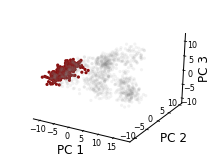

In [33]:
from matplotlib import pyplot as plt

cell_list = []
for cell in rd.index: #meta.loc[rd.index].Age:
    
    if meta.loc[cell].Age == 'embryonic day 13.5':
        cell_list.append(cell)
    
from matplotlib.gridspec import GridSpec
plt.tight_layout()
fig = plt.figure(figsize=(9*cm, 6.75*cm))
ax = fig.add_subplot(111, projection='3d')
# gs = GridSpec(1,5)
# gs.update(wspace=0.05, hspace=0.10)
# ax = fig.add_subplot(gs[0,0:4], projection='3d')
# ax_2 = fig.add_subplot(gs[0,4])
ax.grid(False)
ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c='grey', s=10, linewidth=0, alpha=0.1, zorder=0)

ax.scatter(rd.loc[cell_list, 'PC_1'], rd.loc[cell_list, 'PC_2'], rd.loc[cell_list, 'PC_3'], 
           c='darkred', s=10, linewidth=0, alpha=1, zorder=2000)
# ax.scatter(rd.PC_1, rd.PC_3, c=colores)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


# ax.set_title('Mouse neurogenesis', fontsize=12)
ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# plt.show()
plt.savefig('../../plots/PCA_neurogenesis3D_e13.png', bbox_inches='tight', res=20000, dpi =2000)

<Figure size 432x288 with 0 Axes>

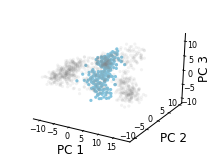

In [34]:
from matplotlib import pyplot as plt

cell_list = []
for cell in rd.index: #meta.loc[rd.index].Age:
    
    if meta.loc[cell].Age == 'postnatal day 1':
        cell_list.append(cell)
    
from matplotlib.gridspec import GridSpec
plt.tight_layout()
fig = plt.figure(figsize=(9*cm, 6.75*cm))
ax = fig.add_subplot(111, projection='3d')
# gs = GridSpec(1,5)
# gs.update(wspace=0.05, hspace=0.10)
# ax = fig.add_subplot(gs[0,0:4], projection='3d')
# ax_2 = fig.add_subplot(gs[0,4])
ax.grid(False)
ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c='grey', s=10, linewidth=0, alpha=0.1, zorder=0)

ax.scatter(rd.loc[cell_list, 'PC_1'], rd.loc[cell_list, 'PC_2'], rd.loc[cell_list, 'PC_3'], 
           c='skyblue', s=10, linewidth=0, alpha=1, zorder=2000)
# ax.scatter(rd.PC_1, rd.PC_3, c=colores)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


# ax.set_title('Mouse neurogenesis', fontsize=12)
ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# plt.show()
plt.savefig('../../plots/PCA_neurogenesis3D_p1.png', bbox_inches='tight', res=20000, dpi =2000)

<Figure size 432x288 with 0 Axes>

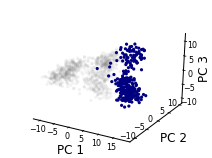

In [35]:
from matplotlib import pyplot as plt

cell_list = []
for cell in rd.index: #meta.loc[rd.index].Age:
    
    if meta.loc[cell].Age == 'postnatal day 90':
        cell_list.append(cell)
    
from matplotlib.gridspec import GridSpec
plt.tight_layout()
fig = plt.figure(figsize=(9*cm, 6.75*cm))
ax = fig.add_subplot(111, projection='3d')
# gs = GridSpec(1,5)
# gs.update(wspace=0.05, hspace=0.10)
# ax = fig.add_subplot(gs[0,0:4], projection='3d')
# ax_2 = fig.add_subplot(gs[0,4])
ax.grid(False)
ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c='grey', s=10, linewidth=0, alpha=0.1, zorder=0)

ax.scatter(rd.loc[cell_list, 'PC_1'], rd.loc[cell_list, 'PC_2'], rd.loc[cell_list, 'PC_3'], 
           c='navy', s=10, linewidth=0, alpha=1, zorder=2000)
# ax.scatter(rd.PC_1, rd.PC_3, c=colores)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


# ax.set_title('Mouse neurogenesis', fontsize=12)
ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# plt.show()
plt.savefig('../../plots/PCA_neurogenesis3D_p90.png', bbox_inches='tight', res=20000, dpi =2000)

In [14]:
psix_results = pd.read_csv('../../psix_3D/psix_results.tab.gz', sep='\t', index_col=0)
modules = pd.read_csv('../../psix_3D/modules_3D.tab.gz', sep='\t', index_col=0).Module
psi =  pd.read_csv('tables/psi_3D.tab.gz', sep='\t', index_col=0)
neighbors_psi = pd.read_csv('tables/neighbors_psi_3D.tab.gz', sep='\t', index_col=0)


In [15]:
def plot_PC3_exon(exon):

    from matplotlib.gridspec import GridSpec
    plt.tight_layout()
    fig = plt.figure(figsize=(9*cm*0.75, 6.75*cm*0.75))
    ax = fig.add_subplot(111, projection='3d')
    # gs = GridSpec(1,5)
    # gs.update(wspace=0.05, hspace=0.10)
    # ax = fig.add_subplot(gs[0,0:4], projection='3d')
    # ax_2 = fig.add_subplot(gs[0,4])
    ax.grid(False)
    ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=psi.loc[exon], s=10, linewidth=0, alpha=1)
    # ax.scatter(rd.PC_1, rd.PC_3, c=colores)
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
    ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
    ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
    ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


    # ax.set_title('Mouse neurogenesis', fontsize=12)
    ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
    ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
    ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(exon, fontsize=12)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    plt.show()

#     plt.savefig('../../plots/PCA_' + exon + '.png', bbox_inches='tight', res=20000, dpi =2000)

In [27]:
def plot_PC3_exon_nova():

    from matplotlib.gridspec import GridSpec
    plt.tight_layout()
    fig = plt.figure(figsize=(9*cm*0.75, 6.75*cm*0.75))
    ax = fig.add_subplot(111, projection='3d')
    # gs = GridSpec(1,5)
    # gs.update(wspace=0.05, hspace=0.10)
    # ax = fig.add_subplot(gs[0,0:4], projection='3d')
    # ax_2 = fig.add_subplot(gs[0,4])
    ax.grid(False)
    ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=psi.loc['Nova1_1'], s=10, linewidth=0, alpha=1)
    # ax.scatter(rd.PC_1, rd.PC_3, c=colores)
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
    ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
    ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
    ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


    # ax.set_title('Mouse neurogenesis', fontsize=12)
    ax.set_xlabel('PC 1', fontsize=8,labelpad=-5)
    ax.set_ylabel('PC 2', fontsize=8,labelpad=-5)
    ax.set_zlabel('PC 3', fontsize=8,labelpad=-8, rotation=90)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title('Nova1, exon 4', fontsize=8)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
#     plt.show()

    plt.savefig('../../plots/PCA_Nova1_1.png', bbox_inches='tight', res=20000, dpi =2000)

<IPython.core.display.Javascript object>


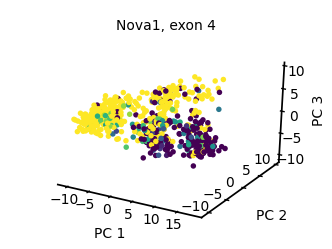

In [28]:
# plot_PC3_exon('Mapt_1')
plot_PC3_exon_nova()

<Figure size 432x288 with 0 Axes>

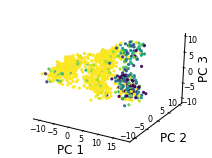

In [12]:
plot_PC3_exon('Cadm1_10')

<Figure size 432x288 with 0 Axes>

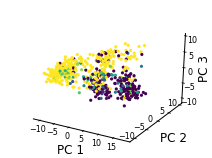

In [13]:
plot_PC3_exon('Nova1_1')

<Figure size 432x288 with 0 Axes>

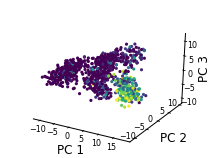

In [14]:
plot_PC3_exon('Stxbp1_2')

<Figure size 432x288 with 0 Axes>

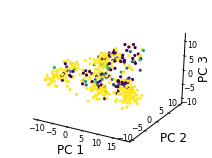

In [18]:
plot_PC3_exon('Nrxn1_4')

In [42]:
def plot_PC3_exon_neighbors(exon):

    from matplotlib.gridspec import GridSpec
    plt.tight_layout()
    fig = plt.figure(figsize=(9*cm, 6.75*cm))
    ax = fig.add_subplot(111, projection='3d')
    # gs = GridSpec(1,5)
    # gs.update(wspace=0.05, hspace=0.10)
    # ax = fig.add_subplot(gs[0,0:4], projection='3d')
    # ax_2 = fig.add_subplot(gs[0,4])
    ax.grid(False)
    ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, 
               c=neighbors_psi.loc[exon].mask(psi.loc[exon].isna()), 
               s=10, linewidth=0, alpha=1, vmin=0, vmax=1)
    # ax.scatter(rd.PC_1, rd.PC_3, c=colores)
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
    ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
    ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
    ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


    # ax.set_title('Mouse neurogenesis', fontsize=12)
    ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
    ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
    ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax.set_title(exon + ' neighbors', fontsize=12)


    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    plt.savefig('../../plots/PCA_' + exon + '_neighbors.png', bbox_inches='tight', res=20000, dpi =2000)

<Figure size 432x288 with 0 Axes>

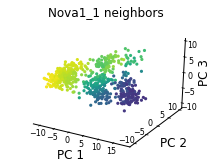

In [43]:
plot_PC3_exon_neighbors('Nova1_1')

<Figure size 432x288 with 0 Axes>

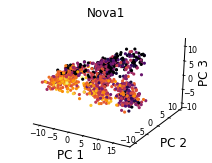

In [46]:
plot_PC3_gene('Nova1')

<Figure size 432x288 with 0 Axes>

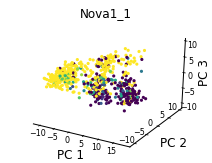

In [47]:
plot_PC3_exon('Nova1_1')

<Figure size 432x288 with 0 Axes>

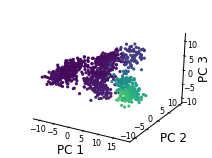

In [40]:
plot_PC3_exon_neighbors('Stxbp1_2')

<Figure size 432x288 with 0 Axes>

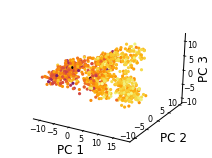

In [41]:
plot_PC3_gene('Stxbp1')


In [24]:
norm_tpm_neuro.shape

(9457, 1067)

In [15]:
def plot_PC3_gene(gene):

    from matplotlib.gridspec import GridSpec
    plt.tight_layout()
    fig = plt.figure(figsize=(9*cm*0.75, 6.75*cm*0.75))
    ax = fig.add_subplot(111, projection='3d')
    # gs = GridSpec(1,5)
    # gs.update(wspace=0.05, hspace=0.10)
    # ax = fig.add_subplot(gs[0,0:4], projection='3d')
    # ax_2 = fig.add_subplot(gs[0,4])
    ax.grid(False)
    ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc[gene], s=10, linewidth=0, alpha=1, cmap='inferno',)
    # ax.scatter(rd.PC_1, rd.PC_3, c=colores)
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
    ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
    ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
    ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


    ax.set_title(gene, fontsize=8)
    ax.set_xlabel('PC 1', fontsize=8,labelpad=-5)
    ax.set_ylabel('PC 2', fontsize=8,labelpad=-5)
    ax.set_zlabel('PC 3', fontsize=8,labelpad=-8, rotation=90)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(gene, fontsize=12)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_zticks([])

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    plt.savefig('../../plots/PCA_' + gene + '.png', bbox_inches='tight', res=20000, dpi =2000)

In [14]:
norm_tpm_neuro.loc['Nova1'].max()

5.416

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


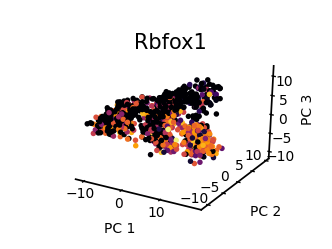

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


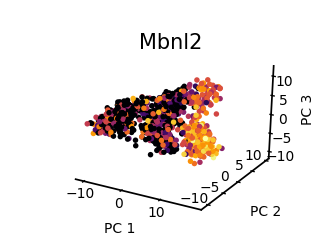

<IPython.core.display.Javascript object>


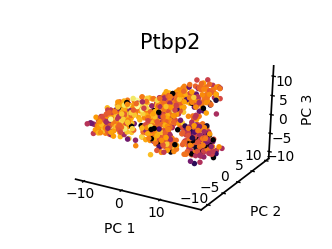

In [16]:
plot_PC3_gene('Rbfox1')
# plot_PC3_gene('Nova1')
plot_PC3_gene('Mbnl2')
plot_PC3_gene('Ptbp2')

In [5]:
data_dir = '../pipeline_output/'
skipped_exons = pd.read_csv(data_dir + 'SE_counts.tab.gz', sep='\t', index_col=0)
tpm = pd.read_csv(data_dir + 'rsem_gene_tpm.tab.gz', sep='\t', index_col=0)
ci = pd.read_csv(data_dir + 'constitutive_introns.tab.gz', sep=',', index_col=0)

In [6]:
ci[neurogenesis_cells].shape

(108481, 1067)

In [7]:
skipped_exons[neurogenesis_cells].shape

(107196, 1067)

In [ ]:
ci[neurogenesis_cells].to_csv('tables/constitutive_introns_filtered.tab.gz', sep='\t', index=True, header=True)
skipped_exons[neurogenesis_cells].to_csv('tables/SE_counts_filtered.tab.gz', sep='\t', index=True, header=True)
tpm[neurogenesis_cells].to_csv('tables/rsem_gene_tpm_filtered.tab.gz', sep='\t', index=True, header=True)

In [9]:
exon_sj = pd.read_csv('tables/SE_counts_filtered.tab.gz', sep='\t', index_col=0)
constitutive_sj = pd.read_csv('tables/constitutive_introns_filtered.tab.gz', sep='\t', index_col=0)

ci_idx = [x + '_CI' for x in constitutive_sj.index]
constitutive_sj.index = ci_idx

all_sj_tables = pd.concat([exon_sj, constitutive_sj])

all_sj_tables.to_csv('tables/splice_junctions_filtered.tab.gz', sep='\t', index=True, header=True)

<Figure size 432x288 with 0 Axes>

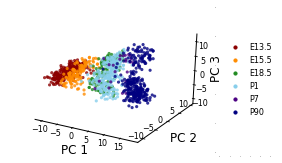

In [13]:
meta = pd.read_csv('../SraRunTable.txt.gz', index_col=0)
rd = pd.read_csv('tables/pc3_rd.tab.gz', sep='\t', index_col=0)

# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})


from matplotlib import pyplot as plt
colores = []
for cell in meta.loc[rd.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
from matplotlib.gridspec import GridSpec
plt.tight_layout()
fig = plt.figure(figsize=(12*cm, 6.75*cm))
# ax = fig.add_subplot(111, projection='3d')
gs = GridSpec(1,5)
gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(gs[0,0:4], projection='3d')
ax_2 = fig.add_subplot(gs[0,4])
ax.grid(False)
ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=colores, s=10, linewidth=0, alpha=0.8)
# ax.scatter(rd.PC_1, rd.PC_3, c=colores)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


# ax.set_title('Mouse neurogenesis', fontsize=12)
ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


ax_2.scatter([-1], [0], c='darkred', label='E13.5', s=10)
ax_2.scatter([0], [0], c='darkorange', label='E15.5', s=10)
ax_2.scatter([0], [0], c='forestgreen', label='E18.5', s=10)
ax_2.scatter([0], [0], c='skyblue', label='P1', s=10)
ax_2.scatter([0], [0], c='indigo', label='P7', s=10)
ax_2.scatter([0], [0], c='navy', label='P90', s=10)
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["bottom"].set_visible(False)
ax_2.spines["left"].set_visible(False)
ax_2.tick_params(labelsize=0, length=0, which='both')
ax_2.set_xlim([2, 3])
ax_2.set_ylim([2, 3])
ax_2.legend(frameon=False, fontsize=8, loc='center left')

plt.savefig('../../plots/PCA_neurogenesis3D_legend.png', bbox_inches='tight', res=20000, dpi =2000)
# plt.savefig('../../plots/PCA_neurogenesis3D.svg', bbox_inches='tight')
# plt.savefig('../../plots/PCA_neurogenesis3D.pdf', bbox_inches='tight')


In [9]:
pseudotime = pd.read_csv('tables/pseudotime.tab.gz', sep='\t', index_col=0)

In [12]:
pseudotime.loc[rd.index, 'lineage_1_pseudotime']

SRR7408400    11.607148
SRR7408401     2.249456
SRR7408404     4.517554
SRR7408413     5.618938
SRR7408414     5.544207
                ...    
SRR7410092    52.166889
SRR7410093    64.521357
SRR7410094    52.847648
SRR7410096    61.623567
SRR7410097    57.778104
Name: lineage_1_pseudotime, Length: 1067, dtype: float64

<IPython.core.display.Javascript object>


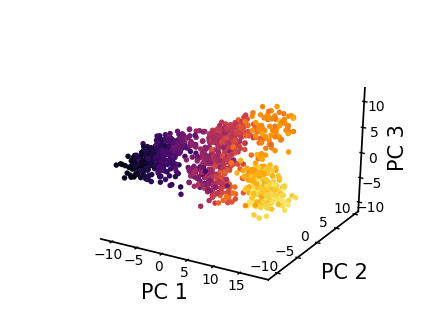

In [21]:
meta = pd.read_csv('../SraRunTable.txt.gz', index_col=0)
rd = pd.read_csv('tables/pc3_rd.tab.gz', sep='\t', index_col=0)

# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})


from matplotlib import pyplot as plt

        
from matplotlib.gridspec import GridSpec
plt.tight_layout()
fig = plt.figure(figsize=(9*cm, 6.75*cm))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=pseudotime.loc[rd.index, 'lineage_1_pseudotime'], 
           cmap='inferno', s=10, linewidth=0, alpha=1)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


# ax.set_title('Mouse neurogenesis', fontsize=12)
ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
# plt.show()
plt.savefig('/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/mouse_brain_development/old/plots/PCA_pseudotime.png', 
            bbox_inches='tight', res=20000, dpi =2000)

<Figure size 432x288 with 0 Axes>

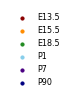

In [29]:
meta = pd.read_csv('../SraRunTable.txt.gz', index_col=0)
rd = pd.read_csv('tables/pc3_rd.tab.gz', sep='\t', index_col=0)

# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})


from matplotlib import pyplot as plt
colores = []
for cell in meta.loc[rd.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
from matplotlib.gridspec import GridSpec
plt.tight_layout()
fig = plt.figure(figsize=(1.5*cm, 4*cm))
ax_2 = fig.add_subplot(111)
# gs = GridSpec(1,5)
# gs.update(wspace=0.05, hspace=0.10)
# ax = fig.add_subplot(gs[0,0:4], projection='3d')
# ax_2 = fig.add_subplot(gs[0,4])
# ax.grid(False)
# ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=colores, s=10, linewidth=0, alpha=0.8)
# # ax.scatter(rd.PC_1, rd.PC_3, c=colores)
# ax.set_yticks([-10, -5, 0, 5, 10])
# ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
# ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
# ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
# ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


# # ax.set_title('Mouse neurogenesis', fontsize=12)
# ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
# ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
# ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)


# ax.xaxis.pane.fill = False
# ax.yaxis.pane.fill = False
# ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
# ax.xaxis.pane.set_edgecolor('w')
# ax.yaxis.pane.set_edgecolor('w')
# ax.zaxis.pane.set_edgecolor('w')


ax_2.scatter([-1], [0], c='darkred', label='E13.5', s=10)
ax_2.scatter([0], [0], c='darkorange', label='E15.5', s=10)
ax_2.scatter([0], [0], c='forestgreen', label='E18.5', s=10)
ax_2.scatter([0], [0], c='skyblue', label='P1', s=10)
ax_2.scatter([0], [0], c='indigo', label='P7', s=10)
ax_2.scatter([0], [0], c='navy', label='P90', s=10)
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["bottom"].set_visible(False)
ax_2.spines["left"].set_visible(False)
ax_2.tick_params(labelsize=0, length=0, which='both', bottom=False, left=False, top=False, labelleft=False, labelbottom=False)
ax_2.set_xlim([2, 3])
ax_2.set_ylim([2, 3])
ax_2.legend(frameon=False, fontsize=8, loc='center left')

plt.savefig('../../plots/PCA_neurogenesis3D_labels.png', bbox_inches='tight', res=20000, dpi =2000)
# plt.savefig('../../plots/PCA_neurogenesis3D.svg', bbox_inches='tight')
# plt.savefig('../../plots/PCA_neurogenesis3D.pdf', bbox_inches='tight')

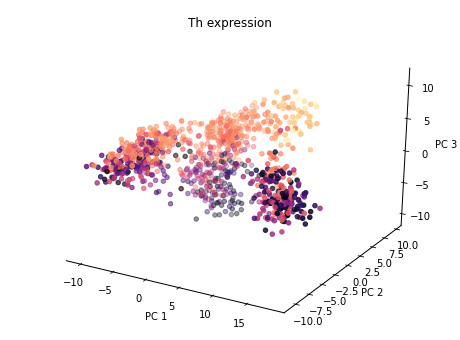

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Th'], cmap='magma')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Th expression')

plt.show()

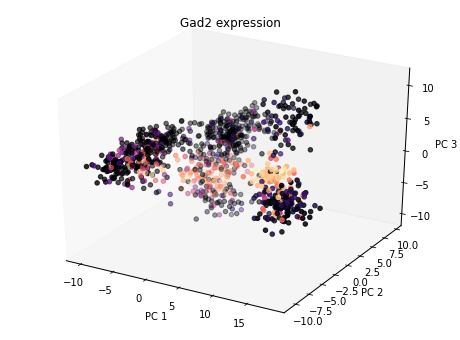

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Gad2'], cmap='magma')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Gad2 expression')

plt.show()

NameError: name 'rd' is not defined

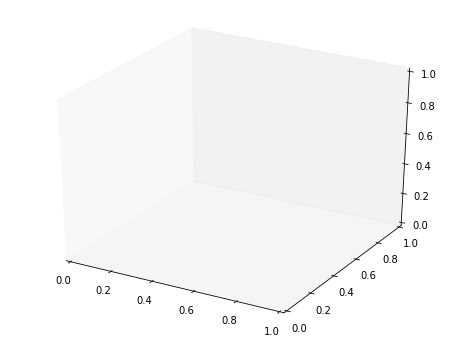

In [89]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Aldh1a1'], cmap='magma')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Nxph4 expression')

plt.show()

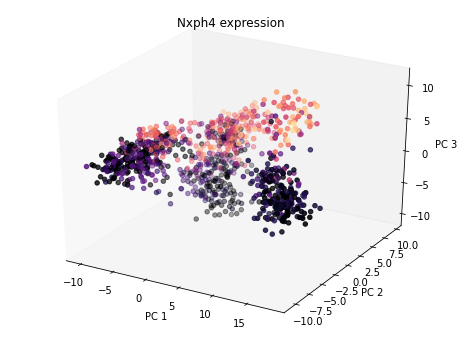

In [226]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm_neuro.loc['Slc6a3'], cmap='magma')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Nxph4 expression')

plt.show()

In [210]:
high_expression = norm_tpm.index[norm_tpm.mean(axis=1) > 0.1]
fano = (norm_tpm.loc[high_expression].var(axis=1)/norm_tpm.loc[high_expression].mean(axis=1)).sort_values()
pca_norm_tiklova = PCA(n_components=30)

scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_tpm.loc[fano.index[-1000:]].T).T,
                             index = fano.index[-1000:], columns = norm_tpm.columns)

# pca_norm_tiklova = pca_norm_tiklova.fit(norm_tpm.loc[var_genes & norm_tpm.index].T)

# pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm.loc[var_genes & norm_tpm.index].T)

pca_norm_tiklova = pca_norm_tiklova.fit_transform(scaled_counts.T)


rd = pd.DataFrame()
for i in range(30):
    rd['PC_' + str(i+1)] = pca_norm_tiklova.T[i]

rd.index = norm_tpm.columns
rd.PC_2 = - rd.PC_2


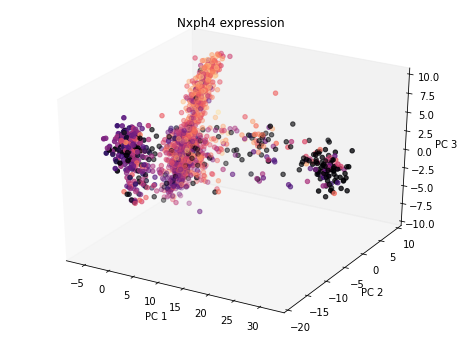

In [216]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)

ax.scatter(rd.PC_1, rd.PC_2, rd.PC_3, c=norm_tpm.loc['Rbfox2'], cmap='magma')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Nxph4 expression')

plt.show()

In [8]:
g = []
for row in cell_metric[0]:
    for i in range(1, len(row)):
        g.append((row[0], row[i]))
    
graph = ig.Graph(g)

In [9]:
graph

In [14]:
from igraph import *
layout = graph.layout("kk")
plot(graph, layout = layout, vertex_size=10, vertex_color=norm_tpm_neuro.loc['Cck', rd.index])

ValueError: palette index used when no palette was given

In [22]:
!pip install cairocffi

     |████████████████████████████████| 70 kB 1.8 MB/s  eta 0:00:01
  Created wheel for cairocffi: filename=cairocffi-1.2.0-py3-none-any.whl size=89545 sha256=58c846445b60032b0a00ea4576bf4e8071df4cf7b6e9970a7f34c14e88907eba
  Stored in directory: /mnt/lareaulab/cfbuenabadn/.cache/pip/wheels/e2/ca/86/9db2824f203afe4bdf5aa6ead017f352fcc90e92f095b78871
Successfully built cairocffi
